# Assignment 3 - Deep Learning

Machine Learning (BBWL), Michael Mommert, FS2023, University of St. Gallen

The **goal** of this assignment is to implement and train a neural network to perform image classification. While a good performance of the resulting trained model is desirable, it is more important to follow the task setup carefully and implement your code following best practices.

The dataset used is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 32x32 RGB images, showing objects from either of 10 different classes.

Your **objectives** are the following:
* Implement a neural network architecture with at least 6 layers for the task of image classification. You can use any architecture you like.
* For each training epoch, output the loss on the training dataset and the loss on the validation dataset. Tune the learning rate using this setup (only use full and half decimal powers, e.g., 0.001, 0.005, 0.01, 0.05, ...) to maximize the accuracy on the validation dataset and prevent overfitting. Visualize the training and validation loss as a function of epoch for the best-performing learning rate in the same plot.
* Evaluate your final trained and tuned model on the test dataset by computing accuracy, precision and recall, visualize the confusion matrix and discuss implications.

This assignment will be **graded** based on:
* whether these objectives have been achieved;
* whether the solution follows best practices;
* how well the approach is documented (e.g., using text cells, plots, etc.);
* how clean the code is.

There are no restrictions on the resources that you can use -- collaborating on assignments is allowed -- but students are not allowed to submit identical code.

There will be a leaderboard comparing the accuracies evaluated on the test dataset; the winner will receive a [grand prize](https://en.wikipedia.org/wiki/Mars_(chocolate_bar))!


-----

The following code cells will setup the environment, download and prepare the data for you. Please do not modify these code cells.

In [ ]:
# import standard python libraries
from datetime import datetime
import numpy as np
import os

# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim

# import sklearn classification evaluation library
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# import plotting capabilities
import matplotlib.pyplot as plt
import seaborn as sns


# init deterministic seed
seed_value = 42
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
torch.cuda.manual_seed(seed_value)
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [ ]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

# create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/data_fmnist'
if not os.path.exists(data_directory): os.makedirs(data_directory)

Mounted at /content/drive


In [ ]:
# download training images and split data (X) from labels (y)
train_path = data_directory + '/train_cifar10'
cifar10_train = torchvision.datasets.CIFAR10(root=train_path, train=True, download=True)
X_train = cifar10_train.data
y_train = cifar10_train.targets

# download evaluation images and split into val and test datasets
eval_path = data_directory + '/eval_cifar10'
cifar10_eval = torchvision.datasets.CIFAR10(root=eval_path, train=False, download=True)
X_val, X_test, y_val, y_test = train_test_split(cifar10_eval.data, cifar10_eval.targets, test_size=0.5, stratify=cifar10_eval.targets, random_state=seed_value)

# define class names
cifar10_classes = cifar10_train.classes

print('Train: {}, Val: {}, Test: {}'.format(len(X_train), len(X_val), len(X_test)))

Files already downloaded and verified
Files already downloaded and verified
Train: 50000, Val: 5000, Test: 5000


----

#1. Explore  the Dataset

We start the assignment by first analyzing the CIFAR-10 dataset. Following we can see that the dataset consists of 10 classes. The dataset has a total of 60000 images. 50'000 are used for training. 5'000 each for validation and testing. The images are RGB images with a resolution of 32x32 pixels.

In [ ]:
#classes
cifar10_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# length training set
len(X_train)

50000

In [ ]:
# length validation set
len(cifar10_eval)

10000

In [ ]:
# shape of validation and test set
y_val, y_test = np.array(y_val), np.array(y_test)
X_val.shape, X_test.shape, y_val.shape, y_test.shape

((5000, 32, 32, 3), (5000, 32, 32, 3), (5000,), (5000,))

Now let's look at the included images in the dataset. To do this, we select 6 random images and add their labels as titles.

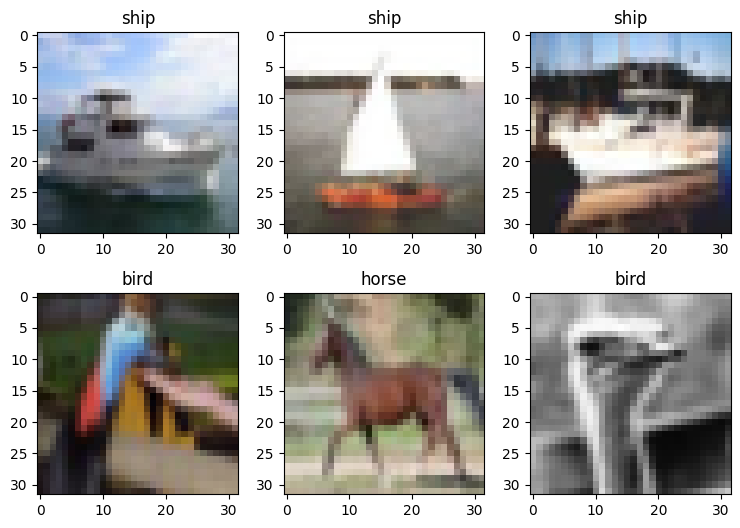

In [ ]:
# random images
image_random = np.random.randint(0, len(X_train), size=6)

# retrieve images and labels
images = X_train[image_random]
labels = np.array(y_train)[image_random]

# plot
f, ax = plt.subplots(2, 3, figsize=(9, 6))
f.subplots_adjust(hspace=0.3)
ax = np.ravel(ax)

for i in range(len(images)):
    ax[i].imshow(images[i], cmap="gray")
    ax[i].set_title(cifar10_train.classes[labels[i]])

# 2. Convolutional Neural Network CNN

In this section, we will implement a Convolutional Neural Network (CNN) for the CIFAR-10 dataset. The goal of the model is to maximize the accuracy so that it can successfully classify the images of the CIFAR-10 dataset.

## 2.1 Network Architecture

The architecture starts with three convolutional layers, each followed by a max-pooling layer. The first convolutional layer takes input images with 3 channels and applies a kernel of size 5x5. The second convolutional layer has 6 input channels and 16 output channels, while the third layer has 16 input channels and 32 output channels.

After the convolutional layers, the image features are flattened and passed through four fully connected layers. The first fully connected layer outputs 200 units. The following layers have decreasing numbers of units, with 150 units in the second layer, 100 units in the third layer, and 50 units in the fourth layer.

The network applies the ReLU activation function after each layer, except for the last layer. This helps introduce non-linearity. In the last layer the LogSoftmax function is used to produce the final class probabilities.

The forward method defines the network's forward pass, where the input images are passed through the convolutional and fully connected layers in sequence.

In [ ]:
# CIFAR10Net network architecture
class CIFAR10Net(nn.Module):

    # class constructor
    def __init__(self):

        # super class constructor
        super(CIFAR10Net, self).__init__()

        # convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)

        # max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

        # max-pooling layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # convolution layer 3
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)

        # max-pooling layer 3
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=1)


        # fc layer 1 - in 32 * 5 * 5, out 200, linearity W*x+b
        self.linear1 = nn.Linear(32 * 5 * 5, 200, bias=True)

        # fc layer 2 - in 200, out 150
        self.linear2 = nn.Linear(200, 150, bias=True)

        # fc layer 3 - in 150, out 100
        self.linear3 = nn.Linear(150, 100)

        # fc layer 4 - in 150, out 100
        self.linear4 = nn.Linear(100, 50)

        # softmax
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # non-linear activation function: ReLU, non-linearity
        self.relu = nn.ReLU(inplace=True)

    # define network forward pass
    def forward(self, images):

        # conv layer 1 forward pass
        x = self.pool1(self.relu(self.conv1(images)))

        # conv layer 2 forward pass
        x = self.pool2(self.relu(self.conv2(x)))

        # conv layer 3 forward pass
        x = self.pool3(self.relu(self.conv3(x)))

        # reshape image pixels: flattening / linearize
        x = x.view(-1, 32 * 5 * 5)

        # fc layer 1 forward pass
        x = self.relu(self.linear1(x))

        # fc layer 2 forward pass
        x = self.relu(self.linear2(x))

        # fc layer 3 forward pass
        x = self.relu(self.linear3(x))

        # layer 4 forward pass
        x = self.logsoftmax(self.linear4(x))

        # return forward pass result
        return x

## 2.2 Prepare Model

In [ ]:
model = CIFAR10Net()

# push CIFAR10Net to device that is enabled
model = model.to(device)

In [ ]:
# print initialized architecture
print("[LOG] CIFAR10Net architecture:\n\n{}\n".format(model))

[LOG] CIFAR10Net architecture:

CIFAR10Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=800, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=150, bias=True)
  (linear3): Linear(in_features=150, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=50, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (relu): ReLU(inplace=True)
)



Below we can see that the CNN model has almost 230'000 parameters.

In [ ]:
# store number of parameters
num_params = 0

# iterate over the distinct parameters and count number of parameters
for param in model.parameters():
    num_params += param.numel()

# print the number of model paramters
print("Our CIFAR10Net model consists of {} parameters.".format(num_params))

Our CIFAR10Net model consists of 226204 parameters.


### 2.2.1 Implement the Loss Function






#### Negative Log-Likelihood NLL


 To train the model we will use NLL as a loss function. NLLI calculates the negative logarithm of the predicted probability of the correct class label. By minimizing this loss during training, the model learns to assign higher probabilities to the correct classes and lower probabilities to incorrect classes.

Formula:
 $$\mathcal{L}^{NLL}_{\theta} (c_i, \hat c_i) = - \frac{1}{N} \sum_{i=1}^N \log (\hat{c}_i) $$

In [ ]:
# define loss function
nll_loss = nn.NLLLoss()
nll_loss = nll_loss.to(device)

#### Learning Rate and Optimization Strategy

We now implement the learning rate and the optimization strategy.
The learning rate determines the step size at which the optimizer updates the model parameters during the training process. As an optimization strategy we use Stochastic Gradient Descent (SGD). SGD updates the model parameters based on the gradients computed during backpropagation.


First a learning rate of 0.001 will be tested.  A small learning rate means smaller parameter updates, leading to slower convergence but potentially better optimization results.

In [ ]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

## 2.3 Neural Network Training
The code below defines the number of training epochs (*num_epochs = 20*), which represents the number of times the model will iterate over the entire dataset during training. This allows the model to learn from the data multiple times and potentially improve its performance.

The model will use a mini-batch size of 64 *(mini_batch_size = 64)* , which determines the number of samples processed in each iteration.

In [ ]:
# number of epochs
num_epochs = 20

# size of mini-batches
mini_batch_size = 64

In [ ]:
# create data loaders using PyTorch
cifar10_train_dataloader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=mini_batch_size, shuffle=True)
cifar10_val_dataloader = torch.utils.data.DataLoader(list(zip(X_val, y_val)), batch_size=len(X_val), shuffle=True)
cifar10_test_dataloader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=len(X_test), shuffle=True)

### 2.3.1 Runnning Network Training and Evaluation
We now train our model on the CIFAR-10 dataset. For this we perform a mini-batch training using a training data loader and calculate the training loss for each epoch. The code also evaluates the model's performance on a validation dataset, calculating the validation loss and accuracy for each epoch.

In [ ]:
# init collection of training epoch losses, validation epoch losses, accuracies
train_epoch_losses = []
val_epoch_losses = []
accuracy_val = []

# train model
for epoch in range(num_epochs):
    model = model.to(device)
    model.train()

    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(cifar10_train_dataloader):

        # reshape and normalize image and convert data to Pytorch tensors
        images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float().to(device)
        labels = torch.Tensor(labels).to(device)

        # run forward pass
        output = model(images)

        # reset graph gradients
        model.zero_grad()

        # determine classification loss
        loss = nll_loss(output, labels)

        # run backward pass
        loss.backward()

        # update network paramaters by optimizing weights based on gradients
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

    # evaluation mode
    model.eval()

    # move to cpu
    model.to("cpu")

    # init collection of mini-batch losses
    val_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(cifar10_val_dataloader):

      # reshape and normalize image and convert data to Pytorch tensors
      images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float()

      # run forward pass
      output = model(images)

      # determine classification loss
      loss = nll_loss(output, labels)

      # collect mini-batch reconstruction loss
      val_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    val_epoch_loss = np.mean(val_mini_batch_losses)
    val_epoch_losses.append(val_epoch_loss)

    # normalize input data and reshape, predict class labels
    predictions = torch.argmax(model(torch.Tensor((X_val/np.array([0.5, 0.5, 0.5]))).float().reshape(-1, 3, 32, 32)).float(), dim=1)

    #accuracy score of the model
    accuracy = accuracy_score(y_val, predictions.detach())
    accuracy_val.append(accuracy)

For a better illustration we now plot two graphs to visualize the training process of the model. The first graph displays the training and validation losses over epochs, providing insights into the model's learning progress and potential overfitting. The second graph illustrates the accuracy of the model on the validation dataset across epochs, indicating how well the model performs over time.

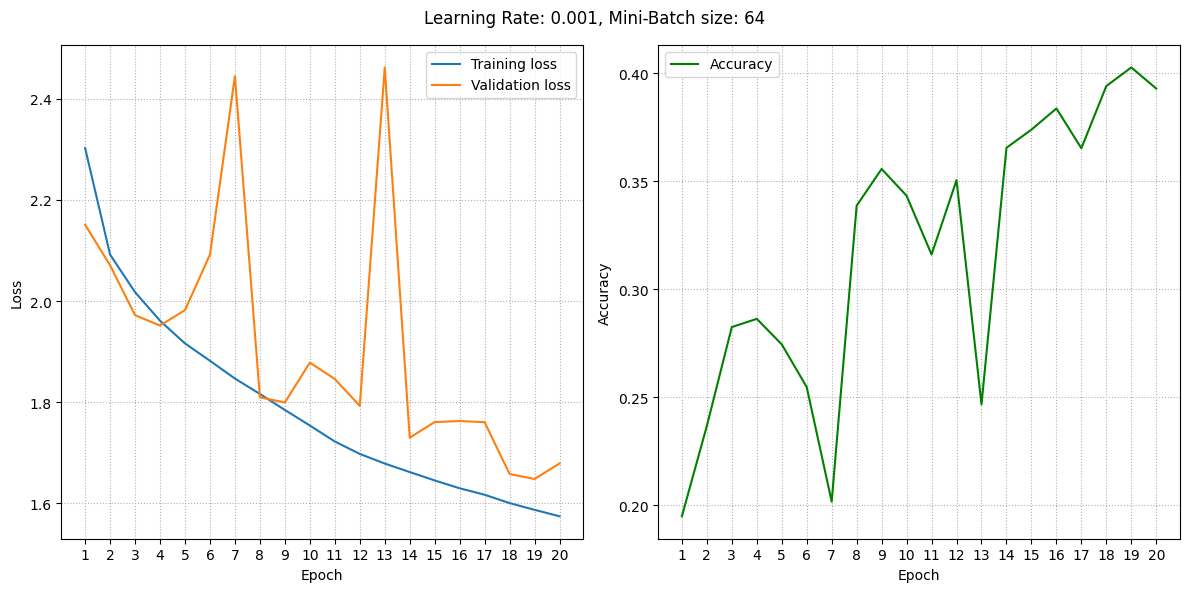

In [ ]:
# plot training and validation losses vs epoch
# plot accuracies vs epoch

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# add grid
ax1.grid(linestyle="dotted")
ax2.grid(linestyle="dotted")

# compare epochs with training and validation losses
ax1.plot(np.array(range(1, len(train_epoch_losses) + 1)), train_epoch_losses, label='Training loss')
ax1.plot(np.array(range(1, len(val_epoch_losses) + 1)), val_epoch_losses, label='Validation loss')
ax2.plot(np.array(range(1, len(accuracy_val) + 1)), accuracy_val, label='Accuracy', color='green')

# add axis legends, titles, ticks
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_xticks(range(1, len(train_epoch_losses) + 1, 1))

ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_xticks(range(1, len(accuracy_val) + 1, 1))
plt.suptitle(f'Learning Rate: {learning_rate}, Mini-Batch size: {mini_batch_size}')

# optimize layout
fig.tight_layout()

# show legend
ax1.legend()
ax2.legend()

# Show the plot
plt.show()

On the left graph we can see that the training loss curve continuously decreases and becomes flatter with the number of epochs. This is a good sign for a successful training. The validation loss curve jumps sometimes very strongly. However, in general it decreases and we can assume that the model is not yet overfitting. The right chart shows us that the accuracy increases with the number of epochs.

Based on these observations, the following section attempts to optimize the model. Will the accuracy continue to increase with more epochs? Can a higher or lower learning rate optimize the model?

## 2.4 Tuning the Model
In this section we try to make the model better by changing the learning rate, the epochs and finally the mini-badge size.



### 2.4.1 Learning Rate
We start by modifying the step size using a selection of different learning rates *learning_rates = [0.001, 0.005, 0.01, 0.05]*, while keeping the other hyperparameters constant.

The results are stored in a DataFrame *df_tuned*. This will help us  to make the plots and to choose the optimal learning rate.

In [ ]:
# import pandas libray
import pandas as pd

# definde learning rates
learning_rates = [0.001, 0.005, 0.01, 0.05]

# create dataframe with multi-level column index
multi_acc = pd.MultiIndex.from_tuples([(lr, 'Training Loss') for lr in learning_rates] + [(lr, 'Validation Loss') for lr in learning_rates] + [(lr, 'Accuracy') for lr in learning_rates])
df_tuned = pd.DataFrame(index=np.arange(1, num_epochs+1), columns= multi_acc).sort_index(axis=1, level=0)

# show df
df_tuned


0.001                                  0.005                \
   Accuracy Training Loss Validation Loss Accuracy Training Loss   
1       NaN           NaN             NaN      NaN           NaN   
2       NaN           NaN             NaN      NaN           NaN   
3       NaN           NaN             NaN      NaN           NaN   
4       NaN           NaN             NaN      NaN           NaN   
5       NaN           NaN             NaN      NaN           NaN   
6       NaN           NaN             NaN      NaN           NaN   
7       NaN           NaN             NaN      NaN           NaN   
8       NaN           NaN             NaN      NaN           NaN   
9       NaN           NaN             NaN      NaN           NaN   
10      NaN           NaN             NaN      NaN           NaN   
11      NaN           NaN             NaN      NaN           NaN   
12      NaN           NaN             NaN      NaN           NaN   
13      NaN           NaN             NaN      NaN           NaN   
14      NaN           NaN             NaN      NaN           NaN   
15      NaN           NaN             NaN      NaN           NaN   
16      NaN           NaN             NaN      NaN           NaN   
17      NaN           NaN             NaN      NaN           NaN   
18      NaN           NaN             NaN      NaN           NaN   
19      NaN           NaN             NaN      NaN           NaN   
20      NaN           NaN             NaN      NaN           NaN   

                      0.010                                  0.050  \
   Validation Loss Accuracy Training Loss Validation Loss Accuracy   
1              NaN      NaN           NaN             NaN      NaN   
2              NaN      NaN           NaN             NaN      NaN   
3              NaN      NaN           NaN             NaN      NaN   
4              NaN      NaN           NaN             NaN      NaN   
5              NaN      NaN           NaN             NaN      NaN   
6              NaN      NaN           NaN             NaN      NaN   
7              NaN      NaN           NaN             NaN      NaN   
8              NaN      NaN           NaN             NaN      NaN   
9              NaN      NaN           NaN             NaN      NaN   
10             NaN      NaN           NaN             NaN      NaN   
11             NaN      NaN           NaN             NaN      NaN   
12             NaN      NaN           NaN             NaN      NaN   
13             NaN      NaN           NaN             NaN      NaN   
14             NaN      NaN           NaN             NaN      NaN   
15             NaN      NaN           NaN             NaN      NaN   
16             NaN      NaN           NaN             NaN      NaN   
17             NaN      NaN           NaN             NaN      NaN   
18             NaN      NaN           NaN             NaN      NaN   
19             NaN      NaN           NaN             NaN      NaN   
20             NaN      NaN           NaN             NaN      NaN   

                                  
   Training Loss Validation Loss  
1            NaN             NaN  
2            NaN             NaN  
3            NaN             NaN  
4            NaN             NaN  
5            NaN             NaN  
6            NaN             NaN  
7            NaN             NaN  
8            NaN             NaN  
9            NaN             NaN  
10           NaN             NaN  
11           NaN             NaN  
12           NaN             NaN  
13           NaN             NaN  
14           NaN             NaN  
15           NaN             NaN  
16           NaN             NaN  
17           NaN             NaN  
18           NaN             NaN  
19           NaN             NaN  
20           NaN             NaN

After creating the DataFrame *df_tuned* we start filling it by iterating over the specified learning rates. The model gets trained for a fixed number of epochs, collecting training and validation losses and accuracy scores.

In [ ]:
# define epochs, mini-batch size, desired learning rates
num_epochs = 20
mini_batch_size = 64
learning_rates = [0.001, 0.005, 0.01, 0.05]

# train and validate model with the different learning rates
for learning_rate in learning_rates:

  # model setup
  model = CIFAR10Net()
  # move to gpu
  model = model.to(device)
  # define stochastic gradient descent as optimization strategy
  optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

  # init collection of training epoch losses, validation epoch losses, accuracies
  train_epoch_losses = []
  val_epoch_losses = []
  accuracy_val = []

  # train model

  for epoch in range(num_epochs):
      #set model in training mode and move to gpu
      model = model.to(device)
      model.train()

      # init collection of mini-batch losses
      train_mini_batch_losses = []

      # iterate over all-mini batches
      for i, (images, labels) in enumerate(cifar10_train_dataloader):

          # reshape and normalize image and convert data to Pytorch tensors
          images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float().to(device)
          labels = torch.Tensor(labels).to(device)

          # run forward pass
          output = model(images)

          # reset graph gradients
          model.zero_grad()

          # determine classification loss
          loss = nll_loss(output, labels)

          # run backward pass
          loss.backward()

          # update network paramaters by optimizing weights based on gradients
          optimizer.step()

          # collect mini-batch reconstruction loss
          train_mini_batch_losses.append(loss.data.item())

      # determine mean min-batch loss of epoch
      train_epoch_loss = np.mean(train_mini_batch_losses)

      # determine mean min-batch loss of epoch
      train_epoch_losses.append(train_epoch_loss)

      # evaluation mode
      model.eval()

      # move to cpu
      model.to("cpu")

      # init collection of mini-batch losses
      val_mini_batch_losses = []

      # iterate over all-mini batches
      for i, (images, labels) in enumerate(cifar10_val_dataloader):

        # reshape and normalize image and convert data to Pytorch tensors
        images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float()

        # run forward pass
        output = model(images)

        # determine classification loss
        loss = nll_loss(output, labels)

        # collect mini-batch reconstruction loss
        val_mini_batch_losses.append(loss.data.item())

      # determine mean min-batch loss of epoch
      val_epoch_loss = np.mean(val_mini_batch_losses)
      val_epoch_losses.append(val_epoch_loss)

      # normalize input data and reshape, predict class labels
      predictions = torch.argmax(model(torch.Tensor((X_val/np.array([0.5, 0.5, 0.5]))).float().reshape(-1, 3, 32, 32)).float(), dim=1)

      # accuracy score of the model
      accuracy = accuracy_score(y_val, predictions.detach())
      accuracy_val.append(accuracy)

      #append to df
      df_tuned.loc[epoch + 1, (learning_rate, "Training Loss")] = train_epoch_loss
      df_tuned.loc[epoch + 1, (learning_rate, "Validation Loss")] = val_epoch_loss
      df_tuned.loc[epoch + 1, (learning_rate, "Accuracy")] = accuracy


Below, we can see that the DataFrame has been successfully filled.

In [ ]:
# show filled df
df_tuned

0.001                                  0.005                \
   Accuracy Training Loss Validation Loss Accuracy Training Loss   
1    0.1992      2.253815        2.183273   0.2408      2.209532   
2     0.231      2.038919        2.087844    0.251      1.985553   
3    0.2762      1.968635         2.07011   0.2642      1.828608   
4    0.2328      1.916151        2.119056   0.3502       1.74979   
5    0.2868      1.876078        1.951169   0.3408      1.695449   
6    0.2582      1.840983        2.185701   0.3856       1.65033   
7    0.3136      1.815096         1.90502   0.3916      1.612972   
8    0.2342      1.785927        2.153571   0.3922      1.583875   
9    0.2782      1.766099        2.195761   0.3914      1.550288   
10    0.332      1.741821        1.885738   0.4134      1.523718   
11   0.3002       1.71941        2.028986    0.414      1.496173   
12   0.3172      1.698061          1.8843   0.4212      1.468446   
13   0.3468      1.681033        1.785071   0.3654      1.444245   
14   0.3612      1.665556        1.747623   0.4078      1.418397   
15   0.3648       1.64754        1.739706   0.3788      1.393658   
16    0.363      1.639251         1.74354   0.3998      1.364495   
17   0.3422      1.620773        1.896718   0.3998      1.341629   
18   0.3798      1.610303        1.714285     0.37       1.31655   
19   0.3848      1.597002        1.729895   0.4236      1.290719   
20    0.391      1.583027         1.68049   0.3706      1.256884   

                      0.010                                  0.050  \
   Validation Loss Accuracy Training Loss Validation Loss Accuracy   
1         2.062318   0.2098      2.200316           2.199      0.1   
2         2.053924    0.283      1.936361        1.953977      0.1   
3         2.089607   0.2218      1.810296        2.273817      0.1   
4         1.812746   0.3528       1.74955        1.793405      0.1   
5         1.834519   0.2844      1.698392        2.248778      0.1   
6         1.697497   0.3178      1.657916        2.105737      0.1   
7         1.651914   0.3732      1.621764        1.727034      0.1   
8         1.682338   0.3496      1.588106         1.81964      0.1   
9         1.678879   0.3724      1.553967        1.741071      0.1   
10        1.656927   0.3792      1.525212        1.841198      0.1   
11         1.61721    0.391      1.496822        1.725219      0.1   
12        1.645854   0.4036      1.471949        1.706478      0.1   
13        1.834926   0.3932      1.442724        1.724703      0.1   
14        1.678666   0.4044      1.408624        1.723929      0.1   
15        1.980421   0.3644      1.384788        1.845329      0.1   
16        1.752348   0.4158      1.350901        1.685847      0.1   
17        1.767264   0.4054      1.324459        1.714538      0.1   
18        1.948589   0.3828      1.294086        1.789715      0.1   
19        1.657307    0.402        1.2648         1.76098      0.1   
20        1.866769    0.399      1.235292        1.963501      0.1   

                                  
   Training Loss Validation Loss  
1       2.653487        2.375184  
2       2.320225        2.314551  
3       2.315683        2.341822  
4        2.31351        2.327198  
5        2.31359        2.321765  
6       2.312302        2.312481  
7        2.31112        2.318725  
8        2.31069        2.312356  
9       2.310295        2.316689  
10      2.309634        2.311245  
11      2.309764        2.307018  
12      2.309292        2.320906  
13       2.30914        2.315179  
14      2.308714        2.308865  
15      2.308666        2.309231  
16       2.30826        2.309803  
17      2.308116        2.309514  
18      2.307558        2.311646  
19      2.307863        2.310276  
20      2.307923         2.31359

Now, we use the data from *df_tuned* to plot graphs as in *2.3.1*. This allows us to visualize and analyze the results of the training and evaluation process more effectively.

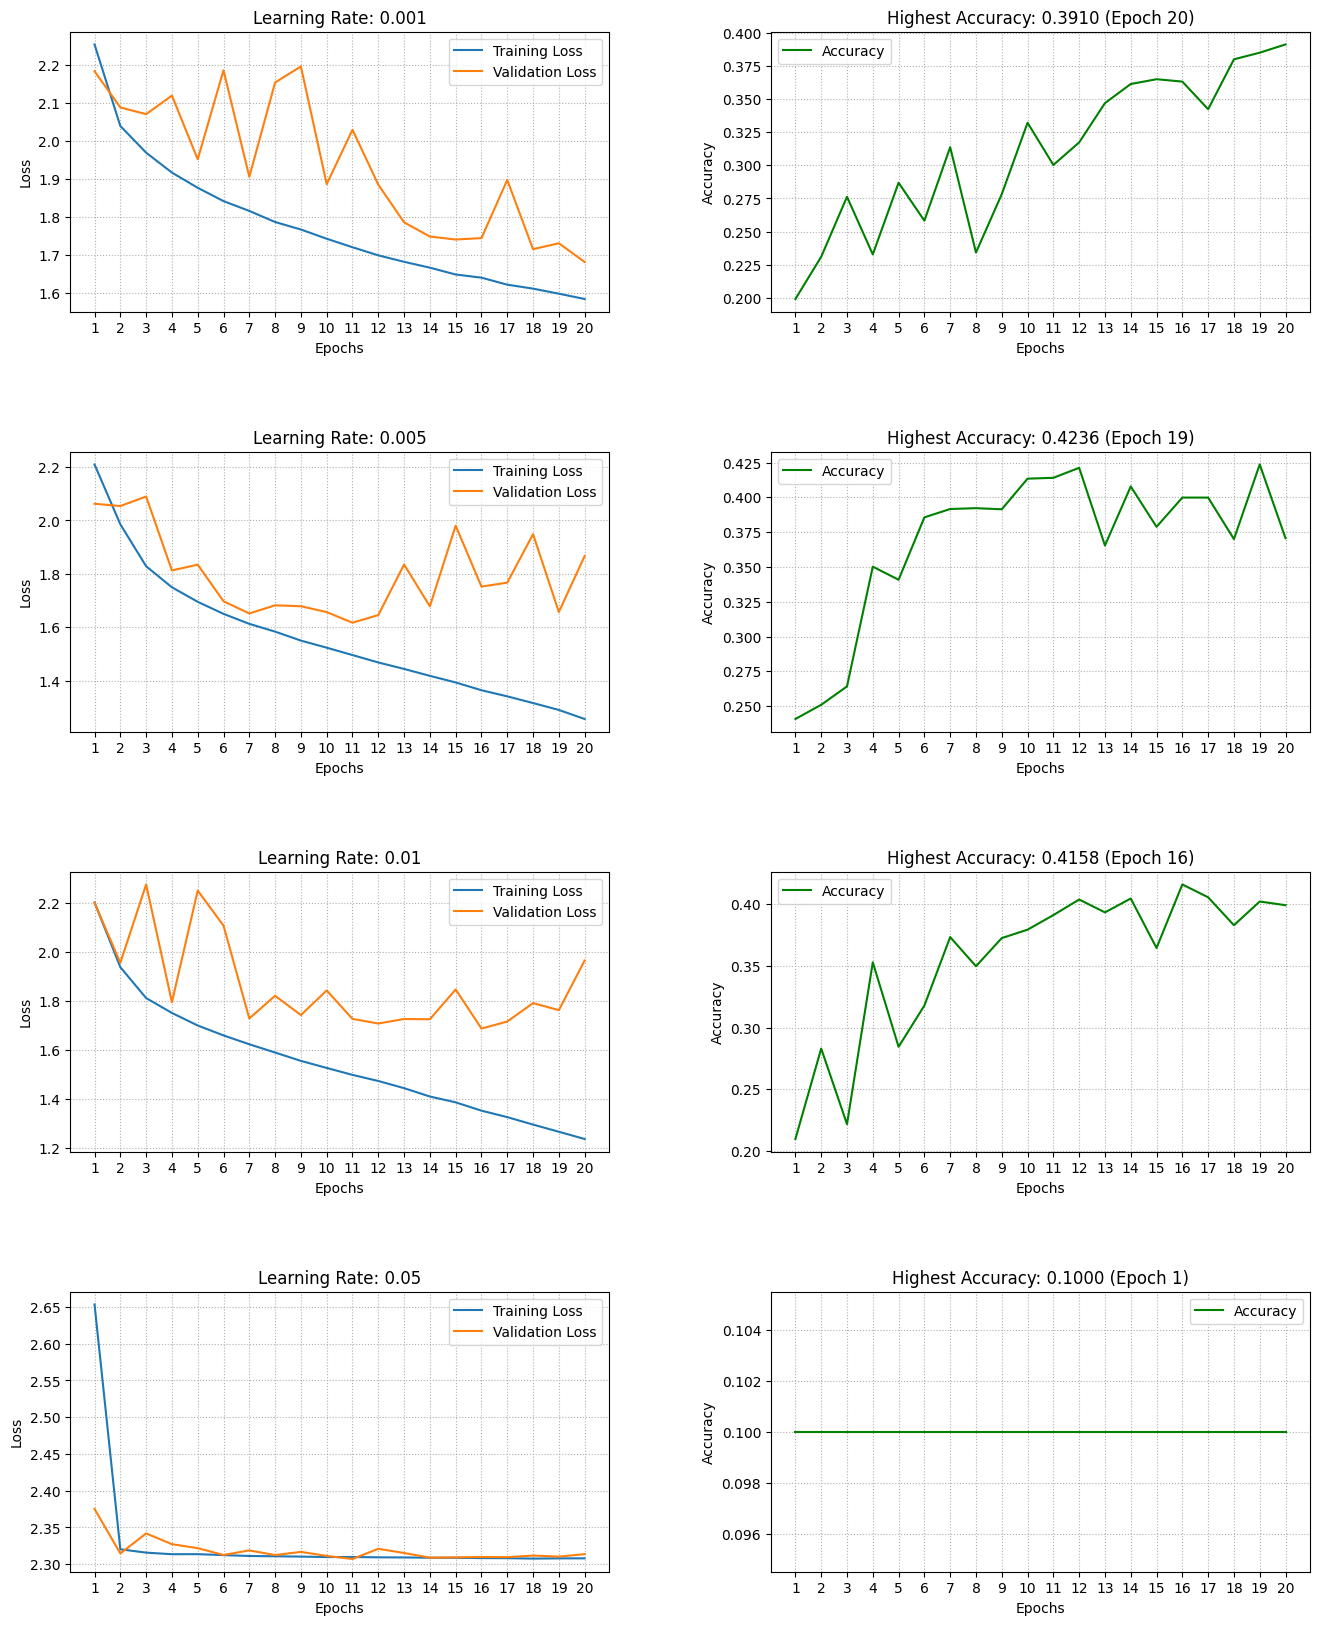

In [ ]:
# create plot
fig, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = np.ravel(axs)

# iterate over all learning rate rows in the dataframe
for i, lr in enumerate(learning_rates):
    # filter data for current learning rate
    data_loss = df_tuned.loc[:, (lr, "Training Loss")], df_tuned.loc[:, (lr, "Validation Loss")]
    data_acc = df_tuned.loc[:, (lr, "Accuracy")]

    # convert accuracy values to numeric
    data_acc = pd.to_numeric(data_acc)

    # get highest accuracy and its corresponding epoch
    max_accuracy = data_acc.max()
    epoch_with_max_accuracy = data_acc.idxmax()

    # plot the validation and training loss on first subplot
    axs[i*2].plot(df_tuned.index, data_loss[0].values, label="Training Loss")
    axs[i*2].plot(df_tuned.index, data_loss[1].values, label="Validation Loss")
    axs[i*2].set_title(f"Learning Rate: {lr}")
    axs[i*2].set_xlabel("Epochs")
    axs[i*2].set_ylabel("Loss")
    axs[i*2].set_xticks(range(1, num_epochs+1))
    axs[i*2].legend()
    axs[i*2].grid(linestyle="dotted")

    # plot accuracy on second subplot w
    axs[i*2+1].plot(df_tuned.index, data_acc.values, label="Accuracy", color="green")
    axs[i*2+1].set_xlabel("Epochs")
    axs[i*2+1].set_ylabel("Accuracy")
    axs[i*2+1].set_xticks(range(1, num_epochs+1))
    axs[i*2+1].legend()
    axs[i*2+1].grid(linestyle="dotted")
    # set title to highest accuracy and its epoch
    axs[i*2+1].set_title(f"Highest Accuracy: {max_accuracy:.4f} (Epoch {epoch_with_max_accuracy})")

# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# show plot
plt.show()



For the learning rates of *0.005* and *0.01*, it is evident that the validation loss increases with more epochs, indicating overfitting. The higher accuracy compared to the learning rate of *0.001* could be related to overfitting as well. If we were to test the model on the test set, it is possible that the accuracy of the *0.001* learning rate model would be higher than that of the *0.005* or *0.01* models. In the case of the *0.001* learning rate, we observe that both the training and validation losses decrease and could continue to decrease with more epochs, which is why we will further investigate this in the following section.

The observable stagnation and low accuracy in the case of the *0.05* learning rate model could indicate, that the chosen learning rate might be too high, so that the weights couldnt converge and got stuck in a suboptimal solution.




### 2.4.2 Epochs
With the selected learning rate (*0.001*), we now try to find the optimal number of epochs. To do this, we increase the number of epochs *num_epochs = 60* and analyze which epoch has the highest accuracy. We store the results in a new DataFrame *df_tuned2*.

Increasing the number of epochs allows the model to learn from the data for a longer period, potentially improving its performance and convergence. However, setting too many epochs may lead to overfitting if the model starts to memorize the training data instead of learning general patterns.

In [ ]:
# define epochs, mini-batch size, desired learning rates
num_epochs = 60
mini_batch_size = 64
learning_rates = [0.001]

# create dataframe with multi-level column index
multi_acc = pd.MultiIndex.from_tuples([(lr, 'Training Loss') for lr in learning_rates] + [(lr, 'Validation Loss') for lr in learning_rates] + [(lr, 'Accuracy') for lr in learning_rates])
df_tuned2 = pd.DataFrame(index=np.arange(1, num_epochs+1), columns= multi_acc).sort_index(axis=1, level=0)

# show df
df_tuned2

0.001                              
   Accuracy Training Loss Validation Loss
1       NaN           NaN             NaN
2       NaN           NaN             NaN
3       NaN           NaN             NaN
4       NaN           NaN             NaN
5       NaN           NaN             NaN
6       NaN           NaN             NaN
7       NaN           NaN             NaN
8       NaN           NaN             NaN
9       NaN           NaN             NaN
10      NaN           NaN             NaN
11      NaN           NaN             NaN
12      NaN           NaN             NaN
13      NaN           NaN             NaN
14      NaN           NaN             NaN
15      NaN           NaN             NaN
16      NaN           NaN             NaN
17      NaN           NaN             NaN
18      NaN           NaN             NaN
19      NaN           NaN             NaN
20      NaN           NaN             NaN
21      NaN           NaN             NaN
22      NaN           NaN             NaN
23      NaN           NaN             NaN
24      NaN           NaN             NaN
25      NaN           NaN             NaN
26      NaN           NaN             NaN
27      NaN           NaN             NaN
28      NaN           NaN             NaN
29      NaN           NaN             NaN
30      NaN           NaN             NaN
31      NaN           NaN             NaN
32      NaN           NaN             NaN
33      NaN           NaN             NaN
34      NaN           NaN             NaN
35      NaN           NaN             NaN
36      NaN           NaN             NaN
37      NaN           NaN             NaN
38      NaN           NaN             NaN
39      NaN           NaN             NaN
40      NaN           NaN             NaN
41      NaN           NaN             NaN
42      NaN           NaN             NaN
43      NaN           NaN             NaN
44      NaN           NaN             NaN
45      NaN           NaN             NaN
46      NaN           NaN             NaN
47      NaN           NaN             NaN
48      NaN           NaN             NaN
49      NaN           NaN             NaN
50      NaN           NaN             NaN
51      NaN           NaN             NaN
52      NaN           NaN             NaN
53      NaN           NaN             NaN
54      NaN           NaN             NaN
55      NaN           NaN             NaN
56      NaN           NaN             NaN
57      NaN           NaN             NaN
58      NaN           NaN             NaN
59      NaN           NaN             NaN
60      NaN           NaN             NaN

In this iteration, we train and evaluate the model with a larger number of epochs. The training and validation losses, as well as the accuracy, are recorded for each epoch and stored in the DataFrame *df_tuned2*

In [ ]:
# train and validate model with the different learning rates
for learning_rate in learning_rates:
  # model setup and move to gpu
  model = CIFAR10Net()
  model = model.to(device)
  optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

  # init collection of training and validation epoch losses, accuracies
  train_epoch_losses = []
  val_epoch_losses = []
  accuracy_val = []

  # train model
  # iterate over epochs
  for epoch in range(num_epochs):
      # set model to training
      model = model.to(device)
      model.train()

      # init collection of mini-batch losses
      train_mini_batch_losses = []

      # iterate over all-mini batches
      for i, (images, labels) in enumerate(cifar10_train_dataloader):

          # reshape and normalize image and convert data to Pytorch tensors
          images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float().to(device)
          labels = torch.Tensor(labels).to(device)

          # run forward pass
          output = model(images)

          # reset graph gradients
          model.zero_grad()

          # determine classification loss
          loss = nll_loss(output, labels)

          # run backward pass
          loss.backward()

          # update network paramaters by optimizing weights based on gradients
          optimizer.step()

          # collect mini-batch reconstruction loss
          train_mini_batch_losses.append(loss.data.item())

      # determine mean min-batch loss of epoch
      train_epoch_loss = np.mean(train_mini_batch_losses)

      # determine mean min-batch loss of epoch
      train_epoch_losses.append(train_epoch_loss)

      # evaluation mode
      model.eval()

      # move to cpu
      model.to("cpu")

      # init collection of mini-batch losses
      val_mini_batch_losses = []

      # iterate over all-mini batches
      for i, (images, labels) in enumerate(cifar10_val_dataloader):

        # reshape and normalize image and convert data to Pytorch tensors
        images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float()

        # run forward pass
        output = model(images)

        # determine classification loss
        loss = nll_loss(output, labels)

        # collect mini-batch reconstruction loss
        val_mini_batch_losses.append(loss.data.item())

      # determine mean min-batch loss of epoch
      val_epoch_loss = np.mean(val_mini_batch_losses)
      val_epoch_losses.append(val_epoch_loss)

      # normalize input data and reshape, predict class labels
      predictions = torch.argmax(model(torch.Tensor((X_val/np.array([0.5, 0.5, 0.5]))).float().reshape(-1, 3, 32, 32)).float(), dim=1)

      #accuracy score of the model
      accuracy = accuracy_score(y_val, predictions.detach())
      accuracy_val.append(accuracy)

      # append to df
      df_tuned2.loc[epoch + 1, (learning_rate, "Training Loss")] = train_epoch_loss
      df_tuned2.loc[epoch + 1, (learning_rate, "Validation Loss")] = val_epoch_loss
      df_tuned2.loc[epoch + 1, (learning_rate, "Accuracy")] = accuracy

In [ ]:
# show df
df_tuned2

0.001                              
   Accuracy Training Loss Validation Loss
1    0.1916      2.254981        2.144943
2    0.2538      2.075691        2.024514
3    0.2698      1.988246        2.040301
4     0.312      1.921961        1.873469
5    0.3156      1.874959        1.877985
6    0.3326      1.832231        1.836047
7    0.3168       1.79245        1.861157
8    0.3654      1.754645        1.767713
9    0.3584       1.72961        1.772585
10   0.3648      1.705796        1.775814
11   0.3764      1.688165        1.724772
12   0.3564      1.672196         1.76359
13   0.3832      1.654717        1.721747
14   0.3994      1.640983        1.684575
15   0.3842       1.62672         1.69704
16   0.3334      1.614308        1.998022
17   0.3876      1.599993        1.696851
18   0.3396      1.586817        1.901005
19   0.3652      1.574575        1.760729
20   0.4094       1.56621        1.654506
21   0.3118      1.555045        2.077462
22     0.41      1.543705        1.628456
23    0.391        1.5341        1.694166
24   0.4282      1.521012        1.603402
25   0.4234      1.513875        1.617511
26   0.4226      1.501738         1.59899
27   0.4178      1.493418        1.642592
28   0.4348      1.482881        1.585732
29   0.4028       1.47182        1.675304
30   0.4274      1.463564        1.611925
31   0.4224      1.457475        1.655218
32   0.4346      1.444775        1.584538
33    0.428      1.437367        1.641043
34   0.4258      1.427003        1.637279
35     0.41      1.416904        1.652339
36     0.42       1.40708         1.63068
37    0.448      1.398187        1.549914
38   0.3822      1.391259        1.850845
39   0.4312      1.378162        1.629981
40   0.4236      1.369549        1.665786
41   0.4526      1.360658        1.568057
42   0.4316        1.3505        1.628208
43      0.4      1.341564         1.75391
44   0.4262       1.32946         1.74084
45   0.4242      1.322925        1.677346
46   0.4348      1.312881        1.616685
47   0.4386      1.302627         1.62704
48   0.4398      1.290815        1.656672
49   0.4338      1.281289        1.618429
50   0.4158        1.2716         1.70928
51   0.4236      1.265686        1.665737
52   0.4052      1.248701        1.805986
53   0.4394      1.242225        1.615334
54   0.4398      1.231616        1.674895
55   0.3948      1.222684        1.830045
56   0.4296      1.210953        1.680201
57   0.4448      1.198933        1.668008
58   0.4258      1.187838        1.767285
59   0.4164      1.181944        1.796561
60    0.405      1.168587        1.842978

We now plot the graphs in the same way as we have done in the previous sections.

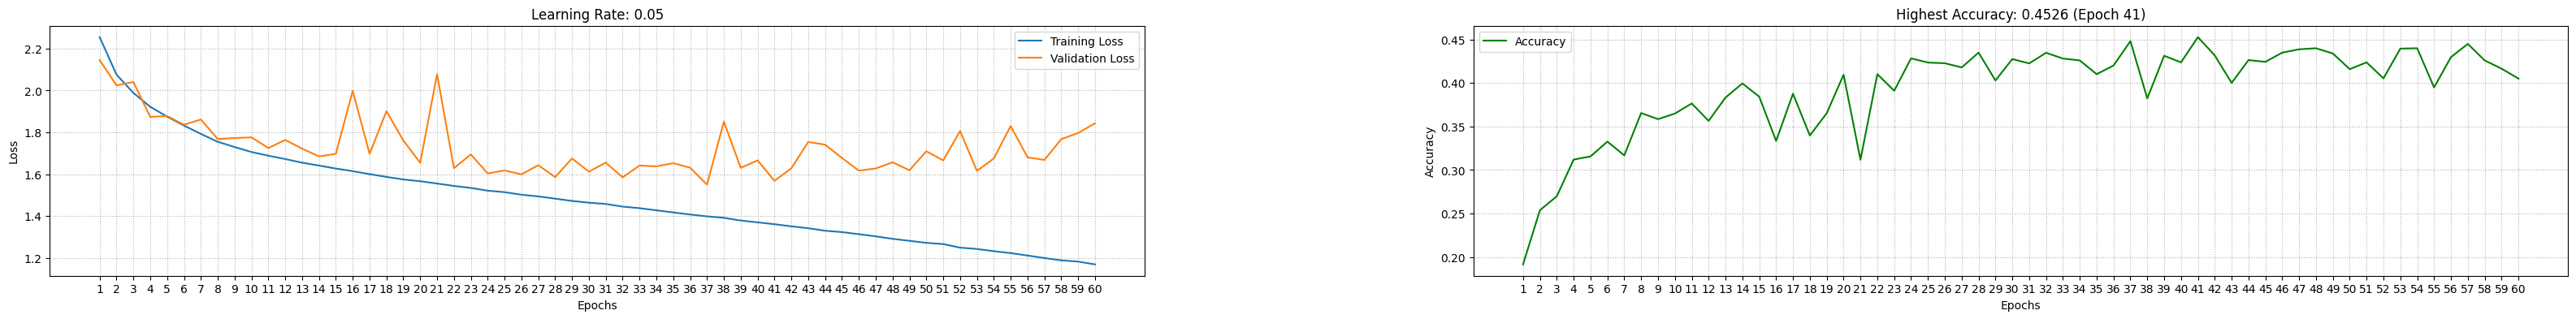

In [ ]:
# create plot
fig, axs = plt.subplots(1, 2, figsize=(40, 4))
axs = np.ravel(axs)


# filter data for current epochs
data_loss = df_tuned2.loc[:, (learning_rate, "Training Loss")], df_tuned2.loc[:, (learning_rate, "Validation Loss")]
data_acc = df_tuned2.loc[:, (learning_rate, "Accuracy")]

# convert accuracy values to numeric
data_acc = pd.to_numeric(data_acc)

# get the highest accuracy and its corresponding epoch
max_accuracy = data_acc.max()
epoch_with_max_accuracy = data_acc.idxmax()

# plot data validation loss and training loss on the first subplot
axs[i*2].plot(df_tuned2.index, data_loss[0].values, label="Training Loss")
axs[i*2].plot(df_tuned2.index, data_loss[1].values, label="Validation Loss")
axs[i*2].set_title(f"Learning Rate: {lr}")
axs[i*2].set_xlabel("Epochs")
axs[i*2].set_ylabel("Loss")
axs[i*2].set_xticks(range(1, num_epochs+1))
axs[i*2].legend()
axs[i*2].grid(linestyle="dotted")

# plot accuracies on the second subplot
axs[i*2+1].plot(df_tuned2.index, data_acc.values, label="Accuracy", color="green")
axs[i*2+1].set_xlabel("Epochs")
axs[i*2+1].set_ylabel("Accuracy")
axs[i*2+1].set_xticks(range(1, num_epochs+1))
axs[i*2+1].legend()
axs[i*2+1].grid(linestyle="dotted")
# set the highest accuracy and its epoch in the title
axs[i*2+1].set_title(f"Highest Accuracy: {max_accuracy:.4f} (Epoch {epoch_with_max_accuracy})")

# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# show t
plt.show()


One can observe that the training loss consistently decreases with the number of epochs and gradually becomes flatter. On the other hand, the validation loss decreases until around the 30th epoch. After that, it stagnates briefly and then starts to slowly increase, indicating the beginning of overfitting. For experimenting with the mini-batch size, we will choose the hyperparameter *num_epochs = 36* since it has a low validation loss and high accuracy. Other possible options could have been *num_epochs = 32 or 28*, both of which also demonstrate high accuracy without showing signs of overfitting.

### 2.4.3 Mini-Batch

With the selected number of Epochs, we now try to find the **optimal mini-batch size**. To do this, we select a number of sizes *mini_batch_size = [32, 64, 128, 256, 512]* and analyze which size has the highest accuracy. We store the results in a new DataFrame *df_tuned3*.


In [ ]:
# define epochs, mini-batch size, learning rates
num_epochs = 36
mini_batch_size = [32, 64, 128, 256, 512]
learning_rate = 0.001

# create dataframe with multi-level column index
multi_acc = pd.MultiIndex.from_tuples([(bs, 'Training Loss') for bs in mini_batch_size] + [(bs, 'Validation Loss') for bs in mini_batch_size] + [(bs, 'Accuracy') for bs in mini_batch_size])
df_tuned3 = pd.DataFrame(index=np.arange(1, num_epochs+1), columns= multi_acc).sort_index(axis=1, level=0)

# show df
df_tuned3

32                                     64                 \
   Accuracy Training Loss Validation Loss Accuracy Training Loss   
1       NaN           NaN             NaN      NaN           NaN   
2       NaN           NaN             NaN      NaN           NaN   
3       NaN           NaN             NaN      NaN           NaN   
4       NaN           NaN             NaN      NaN           NaN   
5       NaN           NaN             NaN      NaN           NaN   
6       NaN           NaN             NaN      NaN           NaN   
7       NaN           NaN             NaN      NaN           NaN   
8       NaN           NaN             NaN      NaN           NaN   
9       NaN           NaN             NaN      NaN           NaN   
10      NaN           NaN             NaN      NaN           NaN   
11      NaN           NaN             NaN      NaN           NaN   
12      NaN           NaN             NaN      NaN           NaN   
13      NaN           NaN             NaN      NaN           NaN   
14      NaN           NaN             NaN      NaN           NaN   
15      NaN           NaN             NaN      NaN           NaN   
16      NaN           NaN             NaN      NaN           NaN   
17      NaN           NaN             NaN      NaN           NaN   
18      NaN           NaN             NaN      NaN           NaN   
19      NaN           NaN             NaN      NaN           NaN   
20      NaN           NaN             NaN      NaN           NaN   
21      NaN           NaN             NaN      NaN           NaN   
22      NaN           NaN             NaN      NaN           NaN   
23      NaN           NaN             NaN      NaN           NaN   
24      NaN           NaN             NaN      NaN           NaN   
25      NaN           NaN             NaN      NaN           NaN   
26      NaN           NaN             NaN      NaN           NaN   
27      NaN           NaN             NaN      NaN           NaN   
28      NaN           NaN             NaN      NaN           NaN   
29      NaN           NaN             NaN      NaN           NaN   
30      NaN           NaN             NaN      NaN           NaN   
31      NaN           NaN             NaN      NaN           NaN   
32      NaN           NaN             NaN      NaN           NaN   
33      NaN           NaN             NaN      NaN           NaN   
34      NaN           NaN             NaN      NaN           NaN   
35      NaN           NaN             NaN      NaN           NaN   
36      NaN           NaN             NaN      NaN           NaN   

                        128                                    256  \
   Validation Loss Accuracy Training Loss Validation Loss Accuracy   
1              NaN      NaN           NaN             NaN      NaN   
2              NaN      NaN           NaN             NaN      NaN   
3              NaN      NaN           NaN             NaN      NaN   
4              NaN      NaN           NaN             NaN      NaN   
5              NaN      NaN           NaN             NaN      NaN   
6              NaN      NaN           NaN             NaN      NaN   
7              NaN      NaN           NaN             NaN      NaN   
8              NaN      NaN           NaN             NaN      NaN   
9              NaN      NaN           NaN             NaN      NaN   
10             NaN      NaN           NaN             NaN      NaN   
11             NaN      NaN           NaN             NaN      NaN   
12             NaN      NaN           NaN             NaN      NaN   
13             NaN      NaN           NaN             NaN      NaN   
14             NaN      NaN           NaN             NaN      NaN   
15             NaN      NaN           NaN             NaN      NaN   
16             NaN      NaN           NaN             NaN      NaN   
17             NaN      NaN           NaN             NaN      NaN   
18             NaN      NaN           NaN             NaN      NaN   
19             NaN     

The code below trains and evaluates the model using different mini-batch sizes. The training and validation losses, as well as the accuracy, are recorded for each epoch and stored in the DataFrame *df_tuned3*. By varying the mini-batch size, we can analyze the impact of batch size on the model performance and identify the optimal size for our final model.

In [ ]:
# train and validate model with the different mini-batch sizes
for bs in mini_batch_size:
  # setup model and move to gpu
  model = CIFAR10Net()
  model = model.to(device)
  optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

  # init collection of training and validation epoch losses, accuracies
  train_epoch_losses = []
  val_epoch_losses = []
  accuracy_val = []

  # train model
  for epoch in range(num_epochs):
      model = model.to(device)
      model.train()

      # init collection of mini-batch losses
      train_mini_batch_losses = []

      # iterate over all-mini batches
      for i, (images, labels) in enumerate(cifar10_train_dataloader):

          # reshape and normalize image and convert data to Pytorch tensors
          images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float().to(device)
          labels = torch.Tensor(labels).to(device)

          # run forward pass
          output = model(images)

          # reset graph gradients
          model.zero_grad()

          # determine classification loss
          loss = nll_loss(output, labels)

          # run backward pass
          loss.backward()

          # update network paramaters by optimizing weights based on gradients
          optimizer.step()

          # collect mini-batch reconstruction loss
          train_mini_batch_losses.append(loss.data.item())

      # determine mean min-batch loss of epoch
      train_epoch_loss = np.mean(train_mini_batch_losses)

      # determine mean min-batch loss of epoch
      train_epoch_losses.append(train_epoch_loss)

      # evaluation mode
      model.eval()

      # move to cpu
      model.to("cpu")

      # init collection of mini-batch losses
      val_mini_batch_losses = []

      # iterate over all-mini batches
      for i, (images, labels) in enumerate(cifar10_val_dataloader):

        # reshape and normalize image and convert data to Pytorch tensors
        images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float()

        # run forward pass
        output = model(images)

        # determine classification loss
        loss = nll_loss(output, labels)

        # collect mini-batch reconstruction loss
        val_mini_batch_losses.append(loss.data.item())

      # determine mean min-batch loss of epoch
      val_epoch_loss = np.mean(val_mini_batch_losses)
      val_epoch_losses.append(val_epoch_loss)

      # normalize input data and reshape, predict class labels
      predictions = torch.argmax(model(torch.Tensor((X_val/np.array([0.5, 0.5, 0.5]))).float().reshape(-1, 3, 32, 32)).float(), dim=1)

      # accuracy score of the model
      accuracy = accuracy_score(y_val, predictions.detach())
      accuracy_val.append(accuracy)

      # append to df
      df_tuned3.loc[epoch + 1, (bs, "Training Loss")] = train_epoch_loss
      df_tuned3.loc[epoch + 1, (bs, "Validation Loss")] = val_epoch_loss
      df_tuned3.loc[epoch + 1, (bs, "Accuracy")] = accuracy

In [ ]:
# show df
df_tuned3

32                                     64                 \
   Accuracy Training Loss Validation Loss Accuracy Training Loss   
1    0.1842      2.267451        2.196029   0.1526      2.207453   
2    0.1502      2.098651        2.362943   0.2406      2.036366   
3    0.2934      2.002543        1.972978   0.2506      1.964423   
4     0.302      1.939115        1.942061   0.2032      1.915871   
5    0.2642      1.894669        2.003797   0.3118      1.882503   
6    0.3278      1.852542        1.871354   0.3196      1.846887   
7    0.3254       1.81193        1.885116   0.3118      1.815232   
8    0.3404       1.76623        1.835451   0.3042      1.779206   
9    0.3432      1.728773        1.862021   0.3732      1.745193   
10   0.3464       1.69502        1.846456   0.3668      1.714832   
11   0.3448      1.669762        1.757969   0.3314      1.691634   
12   0.3802      1.646183        1.753942    0.364       1.66874   
13   0.3754      1.626731        1.710084   0.3762      1.651326   
14   0.4038      1.611262        1.662065   0.3252      1.634293   
15   0.3912      1.593431        1.726323   0.4046      1.620153   
16   0.4216      1.581008        1.609336   0.3926      1.604744   
17    0.385      1.563646         1.76959    0.389      1.592695   
18    0.403      1.551059        1.646948   0.3678      1.576441   
19    0.392      1.540396        1.666653   0.3958      1.564678   
20   0.4092      1.525355        1.655975    0.409      1.553981   
21   0.4002       1.51416        1.650581   0.3658      1.543794   
22   0.4052      1.502817        1.649982   0.3276      1.530481   
23   0.3854      1.491319        1.753096   0.4032      1.518889   
24    0.415      1.478156        1.638069   0.4264      1.507724   
25   0.4096      1.467498        1.669101   0.4298      1.498942   
26   0.3708      1.456639        1.822756   0.3716      1.486563   
27   0.3528      1.445414        1.880182   0.4244      1.475123   
28    0.418      1.433326        1.632427   0.4084      1.465736   
29   0.4156      1.425321        1.638824    0.415      1.453942   
30   0.4214      1.413168        1.601123   0.4378      1.444715   
31   0.4522       1.40527        1.543658   0.4392      1.434946   
32   0.4026      1.391575         1.72707   0.4192      1.424305   
33    0.413      1.382057         1.66181   0.4356      1.413757   
34   0.4012       1.37369        1.695025   0.4274      1.404587   
35   0.4316      1.361126        1.602625    0.406      1.393578   
36    0.429      1.354353        1.585009    0.426      1.382723   

                        128                                    256  \
   Validation Loss Accuracy Training Loss Validation Loss Accuracy   
1         2.247313   0.2284      2.208725        2.078814   0.2202   
2         2.086595   0.2654      2.028806        2.021049   0.2664   
3         2.108849   0.2346      1.956058        2.178439   0.2768   
4         2.222712   0.2892      1.899496        1.980313    0.264   
5         1.907298   0.3254      1.854799        1.871526   0.3256   
6         1.889655   0.3086      1.812445        1.892969   0.3386   
7         1.927429   0.3352      1.769959        1.836773   0.3416   
8         1.923438    0.336      1.738988        1.944276   0.3502   
9         1.745061   0.3074      1.713795        1.945319   0.3278   
10        1.771754   0.3534      1.694374        1.778114   0.3282   
11        1.858528   0.3648      1.675395        1.761405   0.2992   
12         1.81668    0.384       1.65642        1.698249   0.3964   
13        1.711599   0.3516      1.640889        1.849503   0.3484   
14        1.865635   0.3794      1.626175        1.697665    0.365   
15        1.636576   0.3538      1.615577        1.869524   0.3366   
16        1.672719   0.3496      1.603871        1.782781   0.3684   
17        1.699957   0.4012      1.586056        1.667006   0.3882   
18        1.737803   0.3098      1.578524        1.982172   0.3696   
19         1.66507   0.

We now plot the graphs in the same way as we have done in the previous sections.

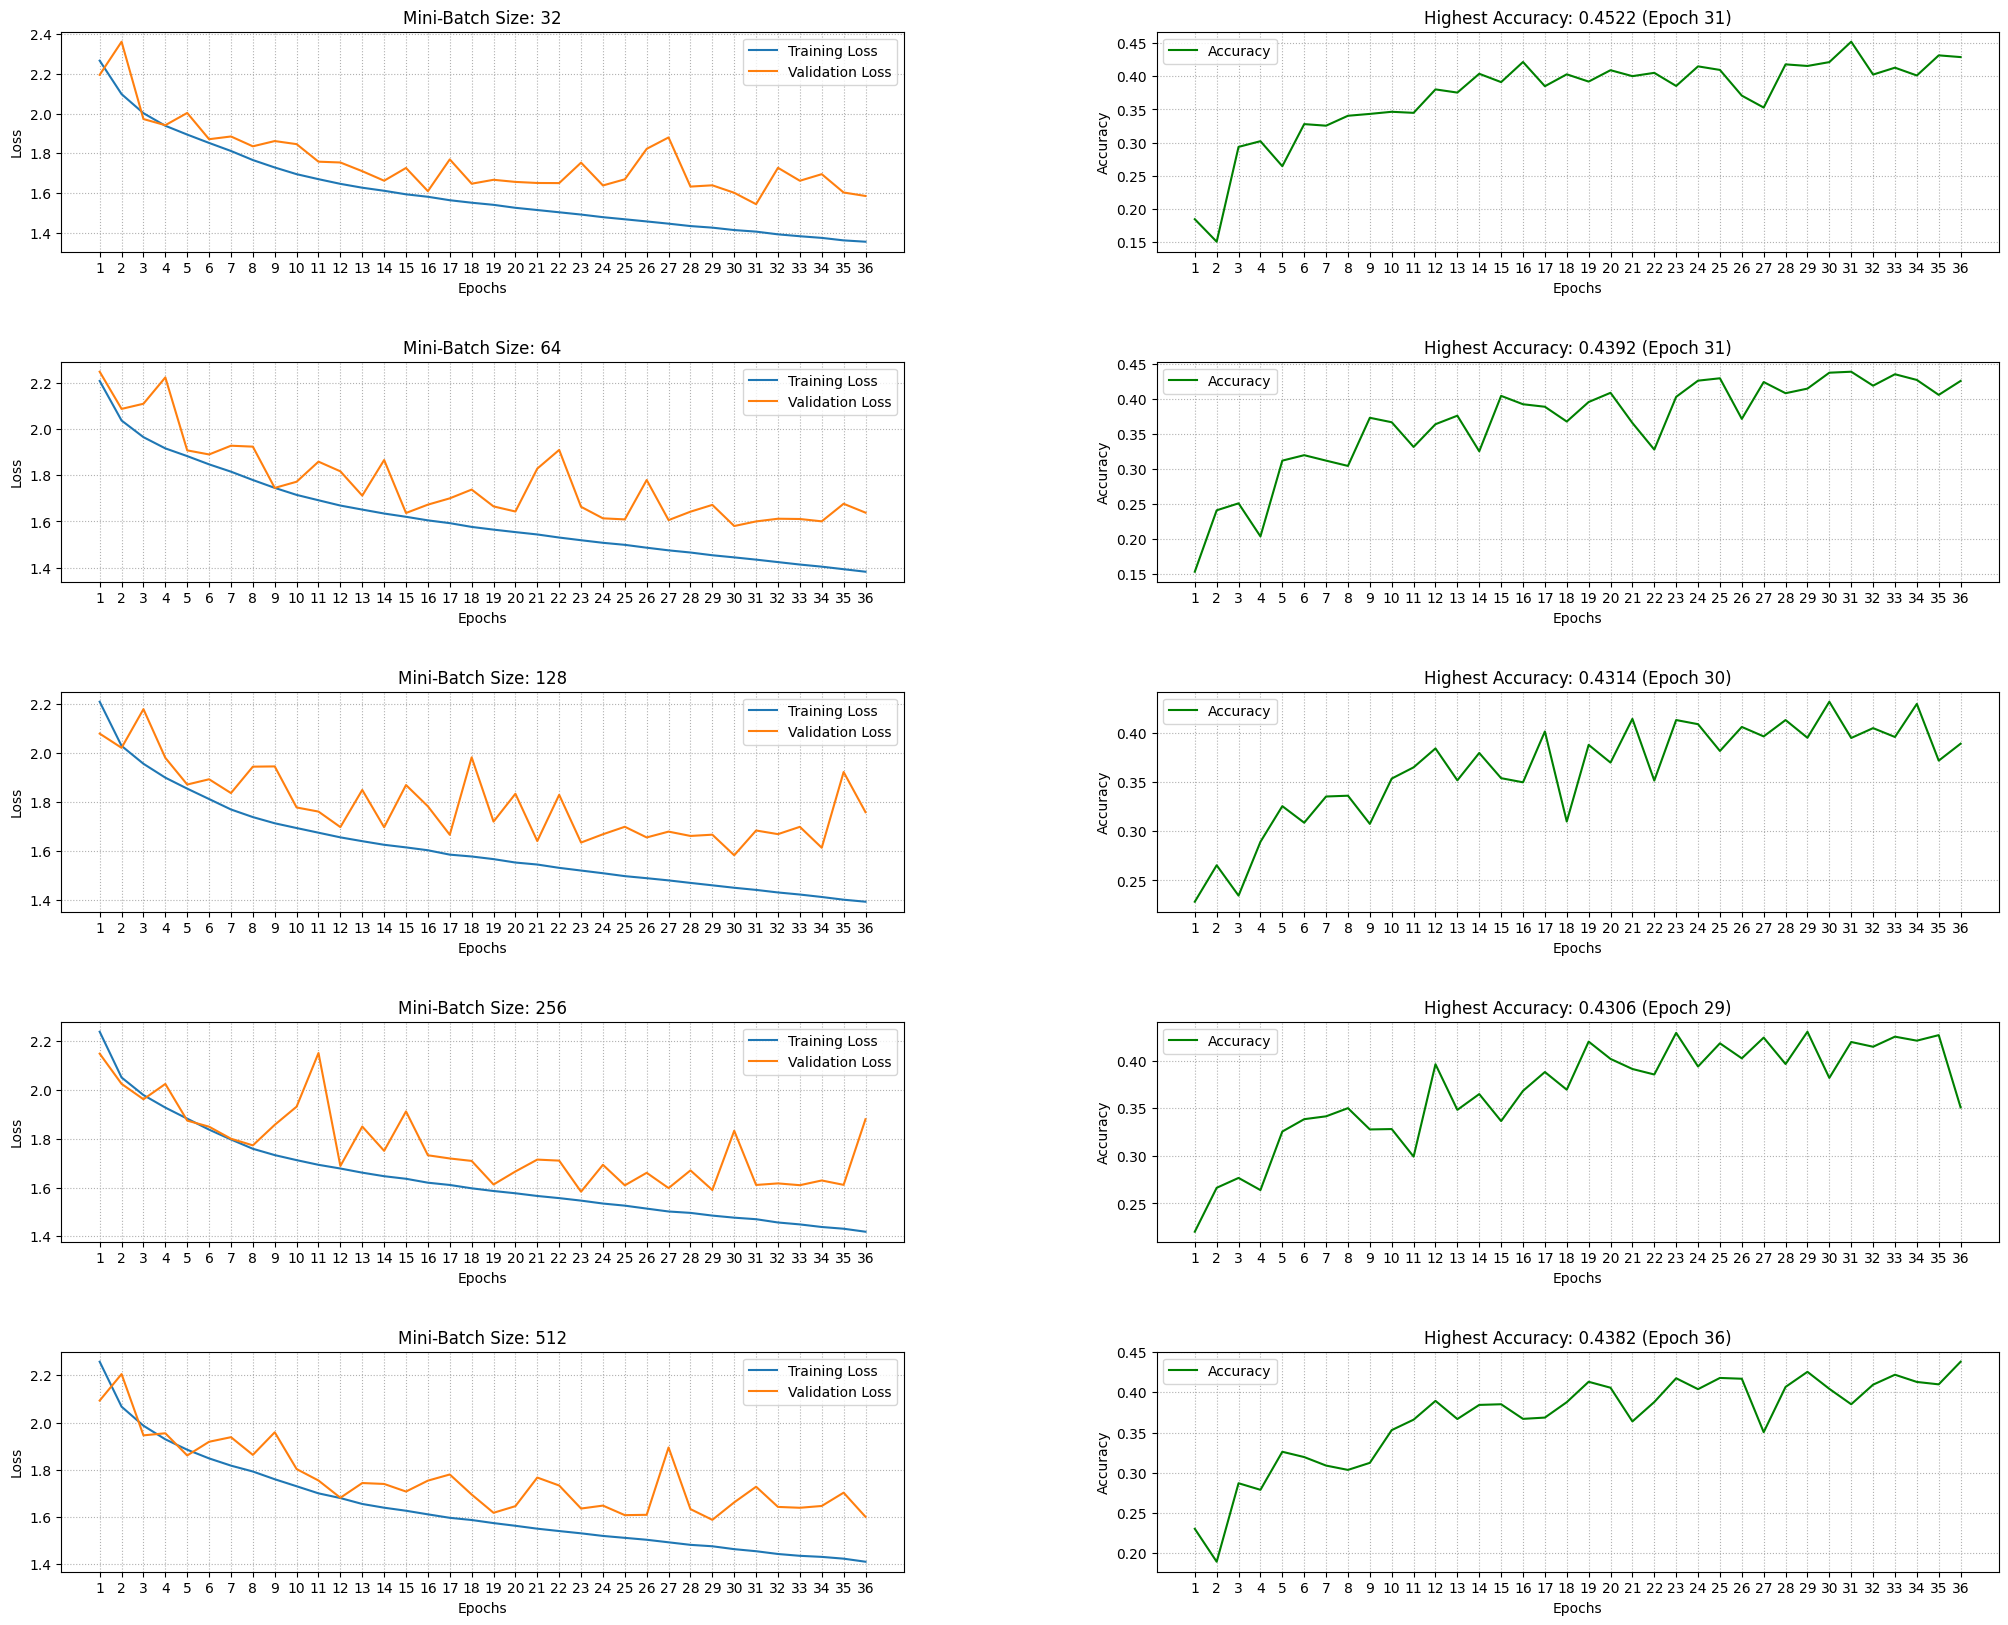

In [ ]:
# create plot
fig, axs = plt.subplots(5, 2, figsize=(25, 20))
axs = np.ravel(axs)

# iterate over mini-batch sizes
for i, bs in enumerate(mini_batch_size):
    # filter the data for the current mini-batch size
    data_loss = df_tuned3.loc[:, (bs, "Training Loss")], df_tuned3.loc[:, (bs, "Validation Loss")]
    data_acc = df_tuned3.loc[:, (bs, "Accuracy")]

    # convert accuracy values to numeric
    data_acc = pd.to_numeric(data_acc)

    # get  highest accuracy and corresponding epoch
    max_accuracy = data_acc.max()
    epoch_with_max_accuracy = data_acc.idxmax()

    # plot validation and training loss on the first subplot
    axs[i*2].plot(df_tuned3.index, data_loss[0].values, label="Training Loss")
    axs[i*2].plot(df_tuned3.index, data_loss[1].values, label="Validation Loss")
    axs[i*2].set_title(f"Mini-Batch Size: {bs}")
    axs[i*2].set_xlabel("Epochs")
    axs[i*2].set_ylabel("Loss")
    axs[i*2].set_xticks(range(1, num_epochs+1))
    axs[i*2].legend()
    axs[i*2].grid(linestyle="dotted")

    # plot accuracies on the second subplot
    axs[i*2+1].plot(df_tuned3.index, data_acc.values, label="Accuracy", color="green")
    axs[i*2+1].set_xlabel("Epochs")
    axs[i*2+1].set_ylabel("Accuracy")
    axs[i*2+1].set_xticks(range(1, num_epochs+1))
    axs[i*2+1].legend()
    axs[i*2+1].grid(linestyle="dotted")
    # put highest accuracy and its epoch in the title
    axs[i*2+1].set_title(f"Highest Accuracy: {max_accuracy:.4f} (Epoch {epoch_with_max_accuracy})")

# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# show
plt.show()


All mini-batch sizes show similar accuracies, but the mini-batch size of *256* shows a significant increase in validation loss towards the end. In general, we observe that as the size increases, the variation in validation loss becomes more significant. Although the accuracy is high at size *64*, we choose size *mini_batch_size = 32*  because of the smooth curve of the validation loss and the higher accuracy. The curve indicates that our model improves consistently and generalizes well.

Possible reasons for the observed behavior could be that larger mini-batch sizes introduce more noise and lead to suboptimal updates of the model parameters. This can lead to less stable training and overfitting. In addition, smaller mini-batches could allow for more frequent updates and better convergence.

## 2.5 Evaluate Final Model
In this section, we train and evaluate our model with the optimized hyperparameters. We use the following values:



> *   Learning Rate: 0.001
> *   Mini-Batch size: 32
> *   Epochs: 36





In 2.5.1 we will look at the Accuracy, the Precision and also the Recall of our model based on the test dataset. To visualize the performance we will use the Confusion Matrix in the section 2.5.2.

In [ ]:
# define hyperparameters
num_epochs = 36
mini_batch_size = 32
learning_rate = 0.001

In [ ]:
# model setup
model = CIFAR10Net()
model = model.to(device)
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

# train model
model.train()

# init collection of mini-batch losses
train_epoch_losses = []

# train the CIFAR100 model
for epoch in range(num_epochs):
  # init collection of mini-batch losses
  train_mini_batch_losses = []

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(cifar10_train_dataloader):

      # reshape and normalize image and convert data to Pytorch tensors
      images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float().to(device)
      labels = torch.Tensor(labels).to(device)

      # run forward pass
      output = model(images)

      # reset graph gradients
      model.zero_grad()

      # determine classification loss
      loss = nll_loss(output, labels)

      # run backward pass
      loss.backward()

      # update network paramaters by optimizing weights based on gradients
      optimizer.step()

      # collect mini-batch reconstruction loss
      train_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  train_epoch_loss = np.mean(train_mini_batch_losses)
  train_epoch_losses.append(train_epoch_loss)

  # print epoch loss
  now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
  print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))



[LOG 20230521-20:21:48] epoch: 0 train-loss: 2.230292793734909
[LOG 20230521-20:21:52] epoch: 1 train-loss: 2.0496238489894916
[LOG 20230521-20:21:56] epoch: 2 train-loss: 1.970474082947997
[LOG 20230521-20:22:01] epoch: 3 train-loss: 1.911019074947328
[LOG 20230521-20:22:05] epoch: 4 train-loss: 1.8504850330864986
[LOG 20230521-20:22:09] epoch: 5 train-loss: 1.8004147465271718
[LOG 20230521-20:22:13] epoch: 6 train-loss: 1.7576739138654431
[LOG 20230521-20:22:18] epoch: 7 train-loss: 1.7222767868615172
[LOG 20230521-20:22:22] epoch: 8 train-loss: 1.696371995274673
[LOG 20230521-20:22:26] epoch: 9 train-loss: 1.6714023366913466
[LOG 20230521-20:22:31] epoch: 10 train-loss: 1.6512464394654764
[LOG 20230521-20:22:35] epoch: 11 train-loss: 1.634651085299909
[LOG 20230521-20:22:39] epoch: 12 train-loss: 1.6128879117843744
[LOG 20230521-20:22:44] epoch: 13 train-loss: 1.5997384614346888
[LOG 20230521-20:22:48] epoch: 14 train-loss: 1.5838138522089595
[LOG 20230521-20:22:52] epoch: 15 train-

Now we will plot only the traininf loss over the different epochs, excluding the accuracy and the validation loss.

Text(0.5, 0.98, ' Learning rate: 0.001    Mini-Batch Size: 32    Epochs: 36')

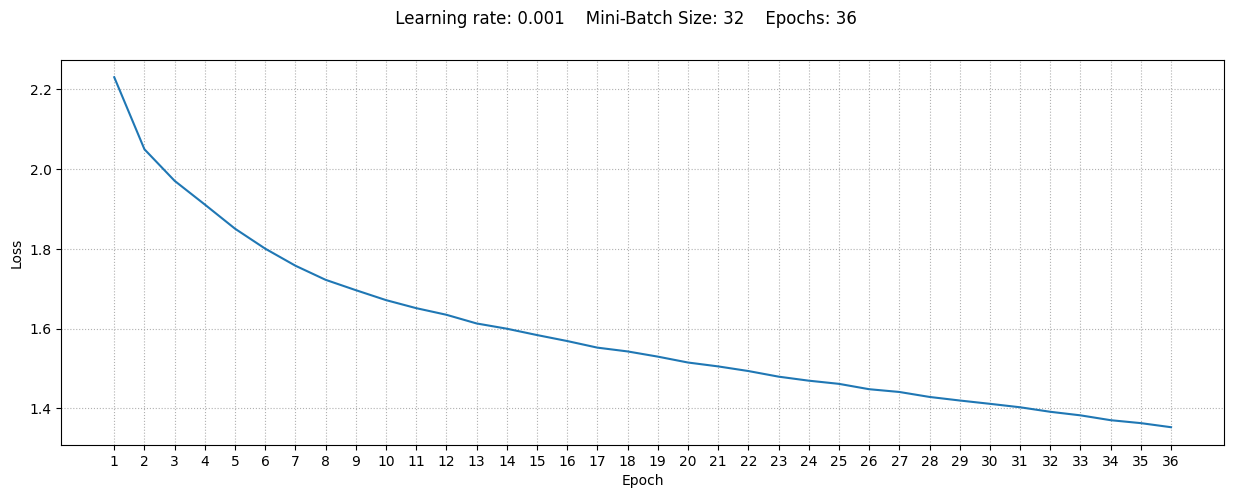

In [ ]:
# prepare plot
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# add grid
ax.grid(linestyle='dotted')

# plot loss vs epochs
ax.plot(np.array(range(1, num_epochs+1)), train_epoch_losses)

# add axis legends and grid
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(range(1, len(train_epoch_losses) + 1, 1))
ax.grid(linestyle = "dotted")

# add title
plt.suptitle(f' Learning rate: {learning_rate}    Mini-Batch Size: {mini_batch_size}    Epochs: {num_epochs}')


The model should have learned enough, as we have analyzed in the previous sections and as we can see in this plot.

We will now evaluate the mode.

In [ ]:
# evaluation mode
model.eval()

# move model to cpu
model.to('cpu')

# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(cifar10_test_dataloader):

     # reshape and normalize image and convert data to Pytorch tensors
    images = torch.Tensor((images/np.array([0.5, 0.5, 0.5])).reshape(-1, 3, 32, 32)).float()

    # run forward pass through the network
    output = model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20230521-20:24:25] eval-loss: 1.6372979879379272


Now let's look at a small example. Let's take two images from the CIFAR-10 set and compare the ground truth label with the predicted label of our model.

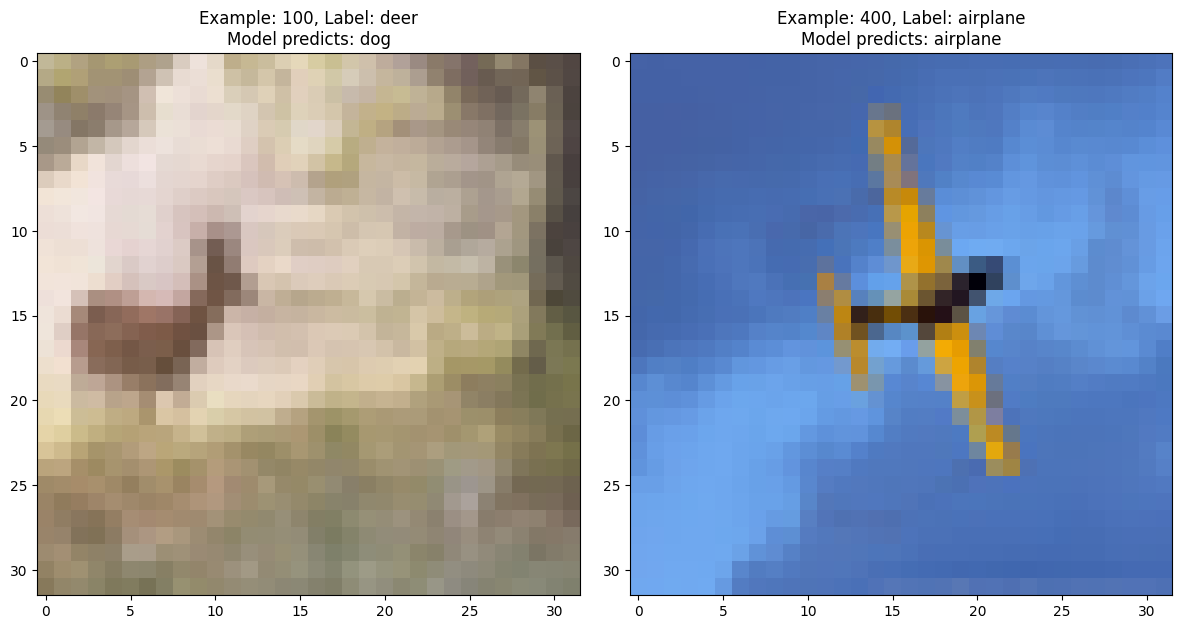

In [ ]:
# chose desired images
image_id1 = 100
image_id2 = 400

# retrieve images and corresponding labels
image1, label1 = X_test[image_id1], y_test[image_id1]
image2, label2 = X_test[image_id2], y_test[image_id2]

# set title with ground truth label and predicted label
title1 = f'Example: {image_id1}, Label: {cifar10_eval.classes[label1]}\nModel predicts: {cifar10_eval.classes[torch.argmax(model(torch.Tensor((image1/np.array([0.5, 0.5, 0.5])).reshape(1, 3, 32, 32)).float()), dim=1).item()]}'
title2 = f'Example: {image_id2}, Label: {cifar10_eval.classes[label2]}\nModel predicts: {cifar10_eval.classes[torch.argmax(model(torch.Tensor((image2/np.array([0.5, 0.5, 0.5])).reshape(1, 3, 32, 32)).float()), dim=1).item()]}'

# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot first image
axs[0].imshow(image1)
axs[0].set_title(title1)

# plot second image
axs[1].imshow(image2)
axs[1].set_title(title2)

# adjust spacing between subplots
plt.tight_layout()

# show plot
plt.show()


As we can see from the graph in section *2.4.3*, our model with the final hyperparameters should have an accuracy of approximately *0.4 - 0.45*. The two images show that the model is indeed capable of recognizing objects such as an airplane, but also struggles with certain classes such as the deer. In the next section Metrics we will further test the model on our test set and provide a detailed analysis of its accuracy, precision, and recall.

### 2.5.1 Metrics









Classification Report: Accuracy, Precision, Recall.

In [ ]:
# import classification report
from sklearn.metrics import classification_report

# normalize input data and reshape, predict class labels
predictions = torch.argmax(model(torch.Tensor((X_test/np.array([0.5, 0.5, 0.5]))).float().reshape(-1, 3, 32, 32)).float(), dim=1)

# classification report
report = classification_report(y_test, predictions)

# print report
print(report)

              precision    recall  f1-score   support

           0       0.48      0.46      0.47       500
           1       0.58      0.39      0.46       500
           2       0.48      0.20      0.28       500
           3       0.32      0.26      0.29       500
           4       0.43      0.25      0.32       500
           5       0.34      0.53      0.42       500
           6       0.55      0.46      0.50       500
           7       0.35      0.67      0.46       500
           8       0.73      0.23      0.35       500
           9       0.35      0.67      0.46       500

    accuracy                           0.41      5000
   macro avg       0.46      0.41      0.40      5000
weighted avg       0.46      0.41      0.40      5000



The final model has:


*   Accuracy 0.41
*   Precison 0.46
*   Recall 0.41



In the classification report, we can also observe that our model performed differently in recognizing different classes. To visualize this beyond numbers, we will create a confusion matrix in the next section.






### 2.5.2 Confusion Matrix

Text(33.222222222222214, 0.5, '[predicted label]')

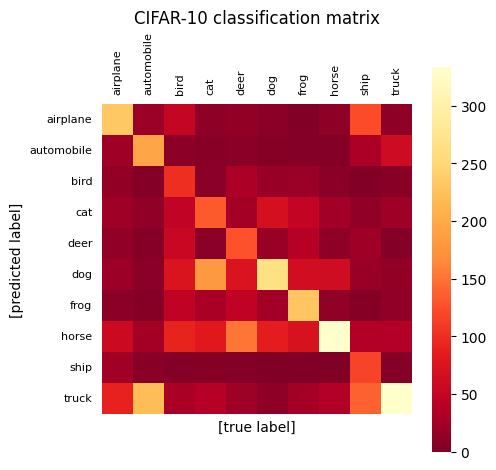

In [ ]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(y_test, predictions.detach())

# plot
plt.figure(figsize=(5, 5))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=False, cbar=True, cmap='YlOrRd_r',
            xticklabels=cifar10_train.classes, yticklabels=cifar10_train.classes)
plt.tick_params(axis='x', which='major', labelsize=8, labelbottom = False, bottom=False,
                top = False, left = False, labeltop=True, labelrotation=90)
plt.tick_params(axis='y', which='major', labelsize=8, labelbottom = False, bottom=False,
                top = False, left = False, labeltop=True)

# set title
plt.title('CIFAR-10 classification matrix')

# set axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]')

As shown in the comparison of the two images in section *2.5*, the model struggles to recognize a Deer compared to identifying a Plane. This can be observed in the confusion matrix through the brightness of the square boxes. Brighter boxes along the main diagonal indicate better predictions of the correct labels. The model performs better in recognizing Planes and Ships, likely due to their distinct features such as a blue background.


Another example is that Cars are often misclassified as Trucks (bright box), and sometimes Ships are also classified as Trucks. In summary the model can correctly recognize some objects, but it also frequently confuses them, especially when the size, background or shape are similar.

#3. Summary

The model has a relatively small number of parameters ~ 230'000. It could have been further increased to potentially achieve better results. However, with an accuracy of 0.41 it can be concluded that CNN enables good results with less parameters. In section 2.4.1 it was observed that the model did not train well with a learning rate of 0.05, I think that the high learning rate was the cause, but I am not quite sure.